In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import datetime
import os.path
import backtrader as bt
import numpy as np
from pprint import pformat
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import math

In [2]:
class maxRiskSizer(bt.Sizer):
    '''
    Returns the number of shares rounded down that can be purchased for the
    max rish tolerance
    '''
    params = (('risk', 0.03),)

    def __init__(self):
        if self.p.risk > 1 or self.p.risk < 0:
            raise ValueError('The risk parameter is a percentage which must be'
                'entered as a float. e.g. 0.5')

    def _getsizing(self, comminfo, cash, data, isbuy):
        if isbuy == True:
            size = math.floor((cash * self.p.risk) / data[0])
        else:
            size = math.floor((cash * self.p.risk) / data[0]) * -1
        return size

In [17]:
class firstStrategy(bt.Strategy):

    def __init__(self):
        self.rsi = bt.indicators.RSI_SMA(self.data.close, period=21)

    def next(self):
        if not self.position:
            if self.rsi < 80:
                self.buy()
        else:
            if self.rsi > 30:
                self.close()

    def notify_trade(self, trade):
        if trade.justopened:
            print('----TRADE OPENED----')
            print('Size: {}'.format(trade.size))
        elif trade.isclosed:
            print('----TRADE CLOSED----')
            print('Profit, Gross {}, Net {}'.format(
                                                round(trade.pnl,2),
                                                round(trade.pnlcomm,2)))
        else:
            return

In [3]:
class SampleStrategy(bt.Strategy):
    
    params = (
        ("smaS", 5),
        ("smaL", 25),
        ("stop_dist", 0.01)
        )
    
    def __init__(self):
        self.smaSmall = bt.indicators.SimpleMovingAverage(period=self.p.smaS)
        self.smaLarge = bt.indicators.SimpleMovingAverage(period=self.p.smaL)
        
    def next(self):
        if not self.position:
            if self.smaSmall > 25 or self.smaLarge > 100:
                stop_price = (self.data.close[0] * (1 - self.p.stop_dist))
                self.buy()
                self.sell(exectype=bt.Order.Stop, price=stop_price)
        
        else:
            if self.smaSmall < 25 or self.smaLarge < 100:
                self.sell()
                
    def notify_trade(self, trade):
        if trade.justopened:
            print('----TRADE OPENED----')
            print('Size: {}'.format(trade.size))
        elif trade.isclosed:
            print('----TRADE CLOSED----')
            print('Profit, Gross {}, Net {}'.format(
                                                round(trade.pnl,2),
                                                round(trade.pnlcomm,2)))
        else:
            return

In [21]:
class BOLLStrat(bt.Strategy):
 
    '''
    This is a simple mean reversion bollinger band strategy.
 
    Entry Critria:
        - Long:
            - Price closes below the lower band
            - Stop Order entry when price crosses back above the lower band
        - Short:
            - Price closes above the upper band
            - Stop order entry when price crosses back below the upper band
    Exit Critria
        - Long/Short: Price touching the median line
    '''
 
    params = (
        ("period", 20),
        ("devfactor", 2),
        ("size", 20),
        ("debug", False)
        )
 
    def __init__(self):
        self.boll = bt.indicators.BollingerBands(period=self.p.period, devfactor=self.p.devfactor)
        #self.sx = bt.indicators.CrossDown(self.data.close, self.boll.lines.top)
        #self.lx = bt.indicators.CrossUp(self.data.close, self.boll.lines.bot)
 
    def next(self):
 
        orders = self.broker.get_orders_open()
 
        # Cancel open orders so we can track the median line
        if orders:
            for order in orders:
                self.broker.cancel(order)
 
        if not self.position:
 
            if self.data.close > self.boll.lines.top:
 
                self.sell(exectype=bt.Order.Stop, price=self.boll.lines.top[0], size=self.p.size)
 
            if self.data.close < self.boll.lines.bot:
                self.buy(exectype=bt.Order.Stop, price=self.boll.lines.bot[0], size=self.p.size)
 
 
        else:
 
 
            if self.position.size > 0:
                self.sell(exectype=bt.Order.Limit, price=self.boll.lines.mid[0], size=self.p.size)
 
            else:
                self.buy(exectype=bt.Order.Limit, price=self.boll.lines.mid[0], size=self.p.size)
 
        if self.p.debug:
            print('---------------------------- NEXT ----------------------------------')
            print("1: Data Name:                            {}".format(data._name))
            print("2: Bar Num:                              {}".format(len(data)))
            print("3: Current date:                         {}".format(data.datetime.datetime()))
            print('4: Open:                                 {}'.format(data.open[0]))
            print('5: High:                                 {}'.format(data.high[0]))
            print('6: Low:                                  {}'.format(data.low[0]))
            print('7: Close:                                {}'.format(data.close[0]))
            print('8: Volume:                               {}'.format(data.volume[0]))
            print('9: Position Size:                       {}'.format(self.position.size))
            print('--------------------------------------------------------------------')
 
    def notify_trade(self,trade):
        if trade.isclosed:
            dt = self.data.datetime.date()
 
            #print('---------------------------- TRADE ---------------------------------')
            #print("1: Data Name:                            {}".format(trade.data._name))
            #print("2: Bar Num:                              {}".format(len(trade.data)))
            #print("3: Current date:                         {}".format(dt))
            #print('4: Status:                               Trade Complete')
            #print('5: Ref:                                  {}'.format(trade.ref))
            #print('6: PnL:                                  {}'.format(round(trade.pnl,2)))
            #print('--------------------------------------------------------------------')

----TRADE OPENED----
Size: -122842
----SUMMARY----
Final Portfolio Value: $71344552.70272496
P/L: $-28655447.297275037


<IPython.core.display.Javascript object>


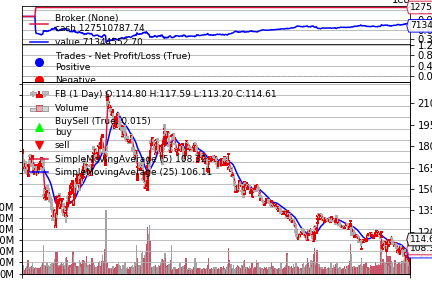

[[<Figure size 432x288 with 4 Axes>]]

In [4]:
#Variable for our starting cash
startcash = 100000000

#Create an instance of cerebro
cerebro = bt.Cerebro()

#Add our strategy
cerebro.addstrategy(SampleStrategy)

#Get Apple data from Yahoo Finance.
#data = bt.feeds.YahooFinanceData(
#    dataname='WMT',
#    fromdate = datetime.datetime(2016,1,1),
#    todate = datetime.datetime(2017,1,1),
#    buffered= True
#    )

datapath = 'FB.csv'
data = bt.feeds.YahooFinanceCSVData(
        dataname=datapath,
        fromdate=datetime.datetime(2016, 2, 2),
        todate=datetime.datetime(2019, 5, 5),
        reverse=True)

#Add the data to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(startcash)

#add the sizer
cerebro.addsizer(maxRiskSizer, risk=0.2)

# Set Comission
cerebro.broker.setcommission(commission=0.65)

# Run over everything
cerebro.run()

#Get final portfolio Value
portvalue = cerebro.broker.getvalue()
pnl = portvalue - startcash

#Print out the final result
print('----SUMMARY----')
print('Final Portfolio Value: ${}'.format(portvalue))
print('P/L: ${}'.format(pnl))

#Finally plot the end results
cerebro.plot(style='candlestick')